# Will I get a ticket if I'm pulled over in University City, MO?
## Utilizing the RandomForest algorithm to predict citation rates

#### First things first! We have to import all of the libraries we need to analyze this data!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pydot
import category_encoders as ce

from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

#### Great! Now we need to import the mostly cleaned DataFrame we already began our analysis on!

In [2]:
cleaned_VSR = pd.read_csv('cleaned_VSR.csv', index_col=0, dtype=object, parse_dates=['STOP_DATE', 'TIME_OF_STOP'])
cleaned_VSR['TIME_OF_STOP'] = cleaned_VSR['TIME_OF_STOP'].dt.time

display(cleaned_VSR.head())

,ORI,DSN,STOP_DATE,SEQ_NO,REF_NO,EVENT_NO,SEX,RACE,AGE_CODE,GEO,...,SECOND_DSN,TIME_OF_STOP,RACE_BEFORE_STOP,RES_JURISDICTION,STOP_NO_ACTION,SEARCH_BOTH,CHRG_TRAFF_VIOL,VIOL_INVESTIGATIVE,STOP_OTHER,STATUS_CODE
0,MO0957300,516,2016-01-01,0,TA00000122,NaN,M,B,B,NaN,...,NaN,22:20:00,N,N,N,NaN,NaN,NaN,NaN,FIN
1,MO0957300,516,2016-01-01,1,TA00000123,NaN,F,B,D,NaN,...,NaN,22:43:00,N,Y,NaN,NaN,NaN,NaN,NaN,FIN
2,MO0957300,516,2016-01-01,2,TA00000124,NaN,M,B,B,NaN,...,NaN,23:10:00,N,N,NaN,NaN,NaN,NaN,NaN,FIN
3,MO0957300,495,2016-01-01,0,TA00000138,NaN,M,B,C,NaN,...,NaN,19:34:00,N,Y,NaN,NaN,NaN,NaN,NaN,FIN
4,MO0957300,506,2016-01-01,0,TA00000147,NaN,F,W,D,NaN,...,NaN,20:18:00,N,Y,NaN,NaN,NaN,NaN,NaN,FIN


#### Hmmm. It's here, but we need to tweak a few more things to get it ready for our RandomForest algorithm!

In [3]:
# Getting a list of all of the column names remaining that we can use for our feature engineering
cleaned_VSR.columns

Index(['ORI', 'DSN', 'STOP_DATE', 'SEQ_NO', 'REF_NO', 'EVENT_NO', 'SEX',
       'RACE', 'AGE_CODE', 'GEO', 'STOP_LOCATION', 'VIOL_MOVING',
       'VIOL_EQUIPMENT', 'VIOL_LICENSE', 'MOVING_SPEED', 'MOVING_LANE',
       'MOVING_TAIL', 'MOVING_CMV', 'MOVING_SIGNAL', 'MOVING_OTHER',
       'WARN_CITA_ISSUED', 'STOP_WARNING', 'STOP_CITATION', 'SEARCH_CONDUCT',
       'DURATION_OF_SEARCH', 'CAUSE_CONSENT', 'CAUSE_DRG_ODOR',
       'CAUSE_DOG_ALERT', 'CAUSE_PLN_VIEW', 'CAUSE_OFF_SFTY', 'CAUSE_INVNTRY',
       'CAUSE_OTHER', 'CAUSE_INC_TO_ARR', 'SEARCHED_PERSON',
       'SEARCHED_PROPERTY', 'CNTR_DISCOVERED', 'CNTR_DRUG_PAR',
       'CNTR_CURRENCY', 'CNTR_WEAPON', 'CNTR_STLN_PROP', 'CNTR_OTHER',
       'SEARCH_ARREST', 'CHRG_WAR_WAN', 'CHRG_DRUG_VIOL', 'CHRG_RESIST_ARR',
       'CHRG_OFF_PERSON', 'CHRG_PROP_CRIME', 'CHRG_OTHER', 'CHRG_DWI',
       'ENTER_DATE', 'ENTER_TIME', 'ENTER_ACID', 'LAST_UPDATE_DATE',
       'LAST_UPDATE_TIME', 'LAST_UPDATE_ACID', 'SECOND_DSN', 'TIME_OF_STOP',
       'R

#### Now let's convert our non-numeric data into a format that the algorithm likes!

In [4]:
# This is only one way to encode the data. I'm choosing to get dummy columns for my features of interest.

# Nominal Categorical Columns
sex_dummies = pd.get_dummies(cleaned_VSR['SEX'], drop_first=True)
race_dummies = pd.get_dummies(cleaned_VSR['RACE'], drop_first=True)
stop_loc_dummies = pd.get_dummies(cleaned_VSR['STOP_LOCATION'], drop_first=True)

# Ordinal Categorical Columns
age_dummies = pd.get_dummies(cleaned_VSR['AGE_CODE'], drop_first=True)
search_dur_dummies = pd.get_dummies(cleaned_VSR['DURATION_OF_SEARCH'], drop_first=True)

# Multi-column Categoricals
viol_dummies = pd.get_dummies(cleaned_VSR[['VIOL_MOVING', 'VIOL_EQUIPMENT', 'VIOL_LICENSE', 'VIOL_INVESTIGATIVE']])
moving_viol_dummies = pd.get_dummies(cleaned_VSR[['MOVING_SPEED', 'MOVING_LANE', 'MOVING_TAIL', 'MOVING_CMV', 'MOVING_SIGNAL', 'MOVING_OTHER']])

# Label dummies
cit_dummies = pd.get_dummies(cleaned_VSR['STOP_CITATION'])

# display(moving_viol_dummies)

#### Before we proceed, I'm going to rename some of the new columns so that they're more readable.

In [5]:
sex_dummies.rename(columns={'M': 'Male'}, inplace=True)
race_dummies.rename(columns={'B': 'Black', 'H': 'Hispanic', 'I': 'Indigenous', 'U': 'Unknown', 'W': 'White'}, inplace=True)
stop_loc_dummies.rename(columns={'I': 'Interstate', 'N': 'County Rd', 'O': 'Other', 'S': 'State Hwy', 'U': 'US Hwy'}, inplace=True)
age_dummies.rename(columns={'B': '18-29', 'C': '30-39', 'D': '40+'}, inplace=True)
search_dur_dummies.rename(columns={'B': '16-30', 'C': '30+'}, inplace=True)

cit_dummies.rename(columns={'C': 'Citation'}, inplace=True)

display(search_dur_dummies)

,16-30,30+
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
17600,0,0
17601,0,0
17602,0,0
17603,0,0


#### Now that the categorical data has been properly encoded, let's construct a *new* DataFrame to feed to our RandomForest model!

In [6]:
VSR_Rand_For = pd.concat([sex_dummies, race_dummies, stop_loc_dummies, age_dummies, search_dur_dummies, \
                          viol_dummies, moving_viol_dummies, cit_dummies], axis=1)

display(VSR_Rand_For.head())

,Male,Black,Hispanic,Indigenous,Unknown,White,Interstate,County Rd,Other,State Hwy,...,VIOL_EQUIPMENT_E,VIOL_LICENSE_L,VIOL_INVESTIGATIVE_I,MOVING_SPEED_S,MOVING_LANE_I,MOVING_TAIL_T,MOVING_CMV_C,MOVING_SIGNAL_F,MOVING_OTHER_O,Citation
0,1,1,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


#### I have to declare my target variable, which is whether or not the vehicle stop resulted in a citation being issued

In [7]:
X = VSR_Rand_For.drop(['Citation'], axis=1)
y = VSR_Rand_For['Citation']

#### The remaining data must now be split up to ensure there is no data leakage

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)
X_train.shape, X_test.shape

((11795, 26), (5810, 26))

In [9]:
display(X_train.columns)

Index(['Male', 'Black', 'Hispanic', 'Indigenous', 'Unknown', 'White',
       'Interstate', 'County Rd', 'Other', 'State Hwy', 'US Hwy', '18-29',
       '30-39', '40+', '16-30', '30+', 'VIOL_MOVING_M', 'VIOL_EQUIPMENT_E',
       'VIOL_LICENSE_L', 'VIOL_INVESTIGATIVE_I', 'MOVING_SPEED_S',
       'MOVING_LANE_I', 'MOVING_TAIL_T', 'MOVING_CMV_C', 'MOVING_SIGNAL_F',
       'MOVING_OTHER_O'],
      dtype='object')

#### We're *finally* ready for our RandomForest algorithm!

In [10]:
# First, we have to instantiate the classifier 
rfc = RandomForestClassifier(n_estimators=10, random_state=42)

# Then we fit the model on our training data
rfc.fit(X_train, y_train)

# Finally, we predict the testing data
y_pred = rfc.predict(X_test)

# How did we do? Let's check the accuracy score!
print('Model accuracy score with 10 decision trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with 10 decision trees : 0.6446


#### Not too bad, but also not too great! Let's check out how our features did, to see if we can start to improve on the model's performance!

In [11]:
feature_scores = pd.Series(rfc.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_scores

VIOL_INVESTIGATIVE_I    0.182494
MOVING_SPEED_S          0.124795
VIOL_EQUIPMENT_E        0.093105
VIOL_MOVING_M           0.079077
Male                    0.074082
County Rd               0.056838
State Hwy               0.038217
Black                   0.036883
VIOL_LICENSE_L          0.036114
30-39                   0.033382
18-29                   0.031624
MOVING_OTHER_O          0.031615
40+                     0.030910
White                   0.030577
Other                   0.023265
Unknown                 0.017889
16-30                   0.016870
MOVING_LANE_I           0.015069
Hispanic                0.011178
Interstate              0.011022
MOVING_SIGNAL_F         0.009564
Indigenous              0.008912
MOVING_TAIL_T           0.003720
30+                     0.001365
MOVING_CMV_C            0.000833
US Hwy                  0.000599
dtype: float64

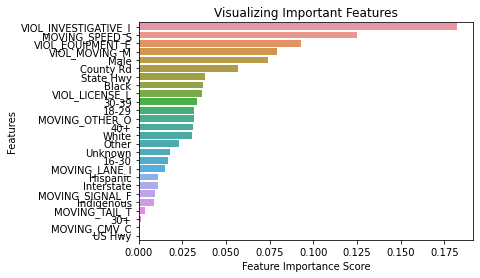

In [12]:
# Let's plot the numbers to show it in a more visual format
sns.barplot(x=feature_scores, y=feature_scores.index)

# Adding labels to the graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')

# Adding a title to the graph
plt.title("Visualizing Important Features")

# Visualizing the graph
plt.show()

#### Okay! Let's try adding in one potential feature that wasn't added at the beginning, remove or replace a few others, and rerun our model!

In [13]:
res_dummies = pd.get_dummies(cleaned_VSR['RES_JURISDICTION'], drop_first = True)
res_dummies.rename(columns={'Y': 'Resident'}, inplace = True)

viol_dummies = pd.get_dummies(cleaned_VSR[['VIOL_EQUIPMENT', 'VIOL_LICENSE', 'VIOL_INVESTIGATIVE']])

VSR_Rand_For2 = pd.concat([sex_dummies, race_dummies, stop_loc_dummies, age_dummies, viol_dummies, moving_viol_dummies, res_dummies, cit_dummies], axis=1)

display(VSR_Rand_For2.head())

X = VSR_Rand_For2.drop(['Citation'], axis=1)
y = VSR_Rand_For2['Citation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)
display(X_train.shape, X_test.shape)

rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

# How did we do this time?
print('The updated model accuracy score with 10 decision trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

,Male,Black,Hispanic,Indigenous,Unknown,White,Interstate,County Rd,Other,State Hwy,...,VIOL_LICENSE_L,VIOL_INVESTIGATIVE_I,MOVING_SPEED_S,MOVING_LANE_I,MOVING_TAIL_T,MOVING_CMV_C,MOVING_SIGNAL_F,MOVING_OTHER_O,Resident,Citation
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
2,1,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,1


(11795, 24)

(5810, 24)

The updated model accuracy score with 10 decision trees : 0.6368


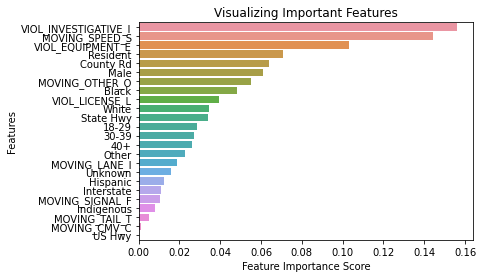

In [14]:
feature_scores = pd.Series(rfc.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_scores

# Plotting again
sns.barplot(x=feature_scores, y=feature_scores.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

#### That didn't help us much, but it also didn't hurt too  much. Let's see if increasing the amount of decision trees in our forest helps!

In [15]:
rfc = RandomForestClassifier(n_estimators=1000, random_state=42)
X = VSR_Rand_For2.drop(['Citation'], axis=1)
y = VSR_Rand_For2['Citation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)
display(X_train.shape, X_test.shape)

rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

# How did we do this time?
print('The updated model accuracy score with 1000 decision trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

(11795, 24)

(5810, 24)

The updated model accuracy score with 1000 decision trees : 0.6403


#### Increasing our number of trees didn't really help us too much! Let's dig into the parameters to investigate further!

In [16]:
from pprint import pprint

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rfc.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


#### Let's try using the RandomizedSearchCV to try to fine tune our hyperparameters!

In [17]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [10, 120, 230, 340, 450, 560, 670, 780, 890, 1000]}


In [18]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rfc = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rfc_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.8min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 120, 230, 340, 450,
                                                         560, 670, 780, 890,
                                                         1000]},
                   random_state=42, verbose=2)

In [19]:
# Which combination worked best?
display(rfc_random.best_params_)

# How does our random best combination fare?
best_random = rfc_random.best_estimator_
y_pred = rfc_random.predict(X_test)

print('The random search model accuracy score is: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

{'n_estimators': 780,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

The random search model accuracy score is: 0.6639


#### There's about a 2% improvement in predictive performance! Let's see if we can now use GridSearchCV to further fine tune!

In [20]:
from sklearn.model_selection import GridSearchCV

# First we create a new parameter grid based on the results of the best random search parameters
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 20, 30, 40],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [2, 4, 6],
    'n_estimators': [500, 700, 900, 1000]
}

# Instantiate the grid search model
rfc = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rfc, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [21]:
# Now we fit the grid search to the data
grid_search.fit(X_train, y_train)

# What were the best parameters this time?
display(grid_search.best_params_)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 17.7min finished


{'bootstrap': True,
 'max_depth': 10,
 'max_features': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 6,
 'n_estimators': 700}

In [22]:
best_grid = grid_search.best_estimator_
y_pred = rfc_random.predict(X_test)

print('The grid search model accuracy score is : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

The grid search model accuracy score is : 0.6639


#### This didn't result in *any* improvement!

#### Conclusion

After fine tuning our baseline model, we were able to increase it's predictive power by ~2%!

It is still only ~66% accurate, however. By choosing a RandomForestClassifier algorithm, we were forced to not use certain features, like our dates and times of each vehicle stop. More research will be done to see if it's possible to include these in a future model, but it's also possible to get more accurate predictions on this largely categorical dataset by employing a differen algorithm altogether.

Other possible tweaks to this model would include using a different criteria, such as entropy/information gain to determine the node splits.

#### Moving forward...

During my research for this project and dataset, I learned that the State of Missouri changed the vehicle stop report template, with a stated goal to 'allow better analysis with the hope of driving more informed dialogue surrounding the report.' (https://ago.mo.gov/home/vehicle-stops-report)

I will be doing a comparative study between the two different report formats once enough data has been collected, in order to independently verify if this stated goal has been reached. As the 2018 analysis (https://github.com/BHuesmann/u_city_2018_vehicle_stops/blob/master/u_city_2018_vehicle_stops.ipynb) showed, there was a **significant** amount of stops that occurred for an 'Other' moving violation, with no further clarification. As I identified that as an area of concern, and moving violations will no longer have their type recorded in these reports, the new numbers must be carefully scrutinized in order to inform others about the effects these changes have had. 